# AoC Leaderboard: A Story Untold

*This notebook explores how the race in the leaderboard of [Advence of Code 2017](adventofcode.com/2017) unfolds.*

I will put all the imports and utility functions at the begining.

In [1]:
import json
import numpy as np
import pandas as pd
import itertools
from math import pi
from IPython.display import Markdown

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 0})

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LabelSet, HoverTool
from bokeh.transform import dodge, linear_cmap
from bokeh.palettes import grey, Plasma256, Viridis256, RdBu, RdYlBu
from bokeh.palettes import Set1 as categorical_colormap
output_notebook()

def flatten(array):
    return list(itertools.chain.from_iterable(array))

Loading BokehJS ...

Now, let's start with reading the json data of a leaderboard that I scraped before. The data includes top 100 users with the highest scores.

In [2]:
file = open('board2017.json')
data = json.loads(file.read())
df = pd.DataFrame(data)
df.sort_values('total_score', inplace=True, ascending=False)
df.head()

,acc_scores,name,scores,times,total_score
0,"[90, 171, 264, 346, 346, 431, 509, 569, 662, 7...",#193354,"[90, 81, 93, 82, 0, 85, 78, 60, 93, 92, 80, 90...","[Dec 01 00:01:46, Dec 01 00:03:13, Dec 02 0...",4247
1,"[100, 200, 300, 400, 496, 596, 695, 771, 871, ...",xiaowuc1,"[100, 100, 100, 100, 96, 100, 99, 76, 100, 100...","[Dec 01 00:00:57, Dec 01 00:01:16, Dec 02 0...",4230
2,"[97, 196, 266, 355, 406, 492, 583, 682, 753, 8...",Robert Xiao (AoC++),"[97, 99, 70, 89, 51, 86, 91, 99, 71, 81, 93, 9...","[Dec 01 00:01:16, Dec 01 00:01:35, Dec 02 0...",3848
3,"[87, 158, 256, 347, 436, 534, 630, 714, 748, 8...",sciyoshi,"[87, 71, 98, 91, 89, 98, 96, 84, 34, 76, 0, 0,...","[Dec 01 00:01:50, Dec 01 00:03:39, Dec 02 0...",3459
4,"[98, 193, 267, 355, 442, 535, 535, 535, 587, 6...",Antonio Molina,"[98, 95, 74, 88, 87, 93, 0, 0, 52, 73, 94, 95,...","[Dec 01 00:01:12, Dec 01 00:02:11, Dec 02 0...",3397


First, I want to see the scores of the top 100 users.

In [3]:
def barchart(df, column):
    source = ColumnDataSource(df)
    hover = HoverTool(tooltips=[
        ('name', '@name'),
        ('score', '@' + column)
    ])

    p = figure(toolbar_location='above', tools=[hover, 'save'], plot_width=960, plot_height=400, x_range=list(df.name))

    p.y_range.start = 0
    p.xgrid.grid_line_color = None
    p.xaxis.major_tick_line_color = None
    p.xaxis.major_label_orientation = pi/3
    p.xaxis.major_label_text_font_size = '6pt'
    
    p.vbar(source=source, x='name', top=column, width=0.85)
    
    show(p)
    
barchart(df, 'total_score')

In [4]:
p = df.iloc[0].total_score
a = int(round(p / len(df.iloc[0].scores)))
t = 101 - a

Markdown("""
The winner has {p} points. This means on average, he/she scores {a} points and finishes top {t} for every single puzzle!!! How does this average position look like for the top 100?
""".format(p=p, a=a, t=t))


The winner has 4247 points. This means on average, he/she scores 85 points and finishes top 16 for every single puzzle!!! How does this average position look like for the top 100?


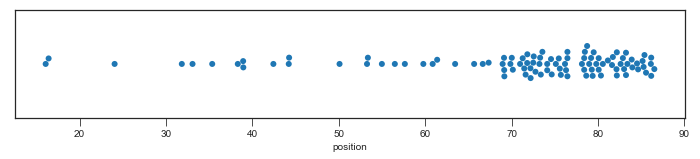

In [5]:
df['position'] = 101 - df.total_score / len(df.iloc[0].scores)
fig, ax = plt.subplots()
fig.set_size_inches(12,2)
ax.grid(False)
sns.swarmplot(data=df, x='position', size=6)

Now, let's drill down to the top 5 guys to and see how they perform in a daily basis. Are they consistent in scoring? I will use a heatmap to show scores with a colored rectangle representing a score of each user per puzzle. Darker cells mean higher scores.

In [6]:
def convert_to_flat_frame(df):
    ''' 
    The current `DataFrame` has a row matching to a user, each containing a series of scores for each puzzle. 
    We need to convert it to a frame with each record as a combination of name and puzzle.
    '''
    names = list(df.name)
    num_names = len(names)
    num_puzzles = len(df.iloc[0].scores)
    puzzles = [str(i) for i in range(1, num_puzzles + 1)]    
    data_names = flatten([[n] * num_puzzles for n in names])
    data_puzzles = flatten([puzzles * num_names])
    scores = flatten(df.scores)
    df = pd.DataFrame({'name': data_names, 'puzzle': data_puzzles, 'score': scores})
    
    return names, puzzles, df

In [7]:
def heatmap(names, puzzles, df, title):
    source = ColumnDataSource(df[df.score > 0])
    hover = HoverTool(tooltips=[
        ('name', '@name'),
        ('puzzle', '@puzzle'),
        ('score', '@score')
    ])

    p = figure(title=title, toolbar_location='above', tools=[hover, 'save'], plot_width=len(puzzles)*18, plot_height=len(names)*35, 
               x_range=puzzles, y_range=names)
          
    p.rect(source=source, x='puzzle', y='name', width=0.9, height=0.9, 
          color=linear_cmap('score', palette=list(reversed(grey(105)[:100])), low=1, high=100))

    # Hide grids and ticks
    p.outline_line_color = None
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None

    show(p)
    
df_top = df.iloc[4::-1,:] # Top 5
names, puzzles, df_flat = convert_to_flat_frame(df_top)
heatmap(names, puzzles, df_flat, 'Heatmap of scores. Darker cells = higher scores. White cells = 0 scores.')

What can we learn from this? 
- #193354 only misses the leaderboard once - the spiral day 3 part 1. But it seems he/she took a steady approach and finished part 2 with a high score.
- Others miss about 5 times. 
- Only puzzle 17 and 18 (both parts in day 9 - stream processing) cause trouble for 2 top guys.

Heatmap is a compact representation, allowing to compare scores across rows (scores per puzzle by each user) and columns (scores per user in each puzzle). But for a continuous color scale, it's difficult to distinguish between close values, say score 100 and 80 have similar darkness.

Now, assume that we're not interested in precise comparison. How's about classifying the scores into some interesting categories: puzzles ranked 1/2/3 (red/orange/green stars), top 10 (filled circles) and top 100 (bordered circles). I call it a podium map.

In [8]:
def podium(names, puzzles, df, xfield, show_zero=False):
    p = figure(title='Podium map. Puzzles ranked 1/2/3: red/orange/green stars, top 10: filled circles, and top 100: bordered circles.', 
               toolbar_location='above', tools=['save'], plot_width=len(puzzles)*18, plot_height=len(names)*35, 
               x_range=puzzles, y_range=names)
    
    # Gold stars for first ranks
    source_first = ColumnDataSource(df[df.score==100])
    p.asterisk(source=source_first, x=xfield, y='name', size=12, line_color='red', fill_color=None, line_width=1.5)
    
    # Silver stars for second ranks
    source_second = ColumnDataSource(df[df.score==99])
    p.asterisk(source=source_second, x=xfield, y='name', size=12, line_color='orange', fill_color=None, line_width=1.5)

    # Bronze stars for third ranks
    source_third = ColumnDataSource(df[df.score==98])
    p.asterisk(source=source_third, x=xfield, y='name', size=12, line_color='green', fill_color=None, line_width=1.5)
    
    # Filled circles for top 10
    source_10 = ColumnDataSource(df[(df.score > 90) & (df.score < 98)])
    p.circle(source=source_10, x=xfield, y='name', size=12, color='grey')
    
    # Bordered circles for top 100
    source_100 = ColumnDataSource(df[(df.score > 0) & (df.score < 91)])
    p.circle(source=source_100, x=xfield, y='name', size=12, line_color='grey', fill_color=None)

    if show_zero:
        source_0 = ColumnDataSource(df[df.score == 0])
        p.x(source=source_0, x=xfield, y='name', size=12, line_color='grey', fill_color=None, line_alpha=0.5)

    # Hide grids and ticks
    p.outline_line_color = None
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None

    show(p)
    
podium(names, puzzles, df_flat, 'puzzle')

It turns out that the top three have similar top 10 finishes but the runner up, xiaowuc1, is way ahead in podium positions. Sort the scores for each person to see the patterns more clearly.

In [9]:
# podium(names, puzzles, df_flat.sort_values(['name', 'score']))
df_rank = df_flat.sort_values(['name', 'score'], ascending=False)
df_rank['rank'] = 0
num_puzzles = len(df.iloc[0].scores)
for i in range(len(names)):
    df_rank.iloc[i * num_puzzles: (i + 1) * num_puzzles, 3] = [str(x) for x in range(1, num_puzzles + 1)]
    
podium(names, puzzles, df_rank, 'rank', True)

#193354 and xiaowuc1 have the same top 10 finishes (32) but xiaowuc1 have many more podium positions. And he came second! So, how could it happen? We can guess it's because the five X at the end. #193354 is more consistent than xiaowuc1.

Let's display the accumaltive scores of top 5 after each puzzle.

In [10]:
def linechart(df):
    num_puzzles = len(df.iloc[0].scores)
    ys = df.loc[:].acc_scores
    num_records = len(ys)
    x = list(range(1, num_puzzles + 1))
    xs = [x] * num_records
    cmap = categorical_colormap[num_records]
    m = min(df.total_score)
    M = max(df.total_score)

    source = ColumnDataSource(data={
        'x': xs,
        'y': ys,
        'lx': [num_puzzles] * len(ys),
#         'ly': df.total_score,
        'ly': range(m, M, int((M-m) / 4)),
        'name': df.name,
        'color': cmap
    })

    labels = LabelSet(source=source, x='lx', y='ly', text='name', x_offset=5, text_baseline='middle', text_font_size='9pt')

    p = figure(toolbar_location='above', tools=['save'], plot_width=960, plot_height=400)
    p.x_range.start = 0
    p.x_range.end = num_puzzles + 7 # plus some for labels
#     p.y_range.start = -100
    p.add_layout(labels)
    
    # Lines
    p.multi_line(source=source, xs='x', ys='y', color='color')
    
    # Circles
    for i in range(num_records):
        p.circle(x=x, y=df.iloc[i].acc_scores, color=cmap[i], size=2)
    
    show(p)
    
linechart(df_top)

The winner (orange color) had a slow start. He was below the other 4 after day 3 (puzzle 6) but then had kept passing other guys. He passed Antonio after day 4, passed sciyoshi after day 7, passed Robert after day 9, and passed xiaowuc1 to become the leader after day 10! #193354 and xiaowuc1 were neck to neck between puzzle 20 and 30, then #193354 sped up and built the lead about 200 points until the final day. Dramma almost happened on the last day, but #193354 kept his title with a 17-point margin to xiaowuc1! What's an exciting race!

Now, just look at the top 2, with a line chart showing their scores per day. We can see that the five times xiaowuc1 failed to score cost him the title.

In [11]:
def linechart2(df):
    num_puzzles = len(df.iloc[0].scores)
    ys = df.loc[:].scores
    num_records = len(ys)
    x = list(range(1, num_puzzles + 1))
    xs = [x] * num_records
    cmap = categorical_colormap[5][3:]
    
    source = ColumnDataSource(data={
        'x': xs,
        'y': ys,
        'lx': [num_puzzles] * len(ys),
        'ly': df.total_score,
        'name': df.name,
        'color': cmap
    })

    labels = LabelSet(source=source, x='lx', y='ly', text='name', x_offset=5, text_baseline='middle', text_font_size='9pt')

    p = figure(toolbar_location=None, tools='', plot_width=960, plot_height=400)
    p.x_range.start = 0
    p.x_range.end = num_puzzles + 6 # plus some for labels
#     p.y_range.start = -100
    p.add_layout(labels)
    
    # Lines
    p.multi_line(source=source, xs='x', ys='y', color='color')
    
    # Circles
    for i in range(num_records):
        p.circle(x=x, y=df.iloc[i].scores, color=cmap[i], size=2)
    
    show(p)
    
linechart2(df.iloc[1::-1,:])
# df.iloc[1::-1,:]

Now, we focus on the winner, showing the difference between his point and the top (if he's not the top) or the second (if he's the top).

In [12]:
file = open('board2017top2.json')
data = json.loads(file.read())
df2 = pd.DataFrame(data)
df2.sort_values('acc_scores', inplace=True)
df2

,acc_scores,name,scores
0,"[100, 99]","[xiaowuc1, Brandon Zhang]","[100, 99]"
1,"[200, 197]","[xiaowuc1, Brandon Zhang]","[100, 98]"
2,"[300, 281]","[xiaowuc1, fwilson42 (AoC++)]","[100, 92]"
3,"[400, 380]","[xiaowuc1, fwilson42 (AoC++)]","[100, 99]"
4,"[496, 442]","[xiaowuc1, Antonio Molina]","[96, 87]"
5,"[596, 535]","[xiaowuc1, Antonio Molina]","[100, 93]"
6,"[695, 630]","[xiaowuc1, sciyoshi]","[99, 96]"
7,"[771, 714]","[xiaowuc1, sciyoshi]","[76, 84]"
8,"[871, 753]","[xiaowuc1, Robert Xiao (AoC++)]","[100, 71]"
9,"[971, 834]","[xiaowuc1, Robert Xiao (AoC++)]","[100, 81]"


This barchart showing the difference between the accumaltive scores of the top 2 may be better than the long text I just wrote above. Blue means #193354 leads and red means xiaowuc leads.

In [13]:
def compute_diffs(dftop, df2):
    winner = dftop.name[-1]
    winner_scores = dftop.iloc[-1].acc_scores
    diffs = []
    
    for i, n in enumerate(df2.name):
        if n[0] != winner:
            diffs.append(winner_scores[i] - df2.iloc[i].acc_scores[0])
        else:
            diffs.append(winner_scores[i] - df2.iloc[i].acc_scores[1])
    
    return diffs

def barchart2(diffs):
    puzzle_ids = [str(i) for i in range(1, len(diffs) + 1)]
    source = ColumnDataSource({
        'puzzle': puzzle_ids,
        'diff': diffs,
        'color': ['#b2182b' if d < 0 else '#2166ac' for d in diffs]
    })
    hover = HoverTool(tooltips=[
        ('puzzle', '@puzzle'),
        ('difference', '@diff')
    ])

    p = figure(toolbar_location='above', tools=[hover, 'save'], plot_width=800, plot_height=300, x_range=puzzle_ids)

    p.xgrid.grid_line_color = None
    p.xaxis.major_tick_line_color = None
    p.xaxis.major_label_text_font_size = '7pt'
    
    max_abs = max(abs(max(diffs)), abs(min(diffs)))
    
    p.vbar(source=source, x='puzzle', top='diff', width=0.9,
           color='color')
#           color=linear_cmap('diff', palette=list(reversed(RdBu[11])), low=-max_abs, high=max_abs))
    
    show(p)
    
diffs = compute_diffs(df_top, df2)
barchart2(diffs)

Or this one showing the difference between the scores of the top 2 for each day. Look at the three high blue bars when #193354 took advantage when xiaowuc1 failed to score.

In [14]:
def compute_diffs2(dftop, df2):
    winner = dftop.name[-1]
    winner_scores = dftop.iloc[-1].scores
    diffs = []
    
    for i, n in enumerate(df2.name):
        if n[0] != winner:
            diffs.append(winner_scores[i] - df2.iloc[i].scores[0])
        else:
            diffs.append(winner_scores[i] - df2.iloc[i].scores[1])
    
    return diffs

barchart2(compute_diffs2(df_top, df2))

I think the winning formula is consistency. It means that you need to be good at different problem types and levels (quick at easy puzzles but also steady at hard ones). You should also have no party or sleeping at the time the puzzles release. Your internet connection should be good as well :-). At the end, it's a fun race. I got 0 point and still be very happy because I learned a lot. I learn Python to do this event and learned Bokeh to build these charts. Again, many thanks to the team that builds an amzing coding event. Merry Christmas and Happy New Year.